# benchmark.ipynb

This notebook contains the text and code for the next blog post in the zero-copy model series, 
title TBD.

The first post explained how to load PyTorch models for inference extremely fast by leveraging the Plasma object store's ability to load numeric data directly from shared memory.

In this post, we talk in more concrete terms about how to use this zero-copy model loading for model serving. We put together a simple model serving system, then set up a microbenchmark that simulates a heavy-tailed traffic pattern.

In [1]:
# Initialization and import code goes in this cell.

# Imports: Python core, then third-party, then local.
# Try to keep each block in alphabetical order, or the linter may get angry.

import asyncio
import copy
import concurrent.futures
import requests
import starlette
import time
import urllib
import os
import json

from typing import Dict, Any, Callable, Tuple, List
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special

import ray
from ray import serve
import torch
import transformers

import zerocopy

# Fix silly warning messages about parallel tokenizers
os.environ['TOKENIZERS_PARALLELISM'] = 'False'


# Reduce the volume of warning messages from `transformers`
transformers.logging.set_verbosity_error()


def reboot_ray():
    if ray.is_initialized():
        ray.shutdown()

    if torch.cuda.is_available():
        return ray.init(num_gpus=1)
    else:
        return ray.init()

# Title of new blog post goes here

*Recap of previous blog post goes here.*



## Scenario

The end-to-end scenario for our benchmark involves supporting an AI chatbot.
The chatbot's conversational AI runs off of a conversation tree. Some of the 
nodes of this tree invoke models.



<!--
The end-to-end scenario for our benchmark involves supporting an AI chatbot.
The chatbot's conversational AI runs off of a conversation tree (**TODO:** What's the best term for this tree?). Some of the nodes of this tree invoke question answering models.

Our benchmark will cover the model serving portion of the chatbot's backend. This 
model serving layer runs question answering (QA) models on behalf of the 
chatbot's conversational AI. The chatbot's conversation tree leads to 4 very different
question answering scenarios, and each scenario has its own dedicated QA
model. Because the chatbot speaks 3 different languages, there are three versions of
each model deployed: one for each language. So the model serving layer runs a total of
12 models to cover the 4 question types and 3 languages.
-->

> **TODO:** Cartoon block diagram of the end-to-end scenario. 
> Diagram should show a user interacting with a chatbot. The chatbot runs off of a conversation tree. 
> Some of the nodes of the conversation tree have question answering models hanging off of them.



## The Models
Our benchmark will cover the model serving portion of the chatbot's backend. This 
model serving layer runs four different types of models:
* *Intent classification* models that determine what category of information the user is interested in.
* *Question answering* models that provide the answers to specific factual questions.
* *Sentiment analysis* models that monitor the user's mood and frustration level.
* *Natural language generation* models that give the chatbot's responses a less scripted flavor.

Because the chatbot speaks 3 different languages, there are three versions of
each model deployed: one for each language. So the model serving layer runs a total of
12 models to cover the 4 model types and 3 languages.

We'll simulate each of these four model types by drawing the most popular model from each category from the [Huggingface model marketplace](https://huggingface.co/models).



### Intent Model

For our intent classification models, we'll use the model [`mrm8488/t5-base-finetuned-e2m-intent`](https://huggingface.co/mrm8488/t5-base-finetuned-e2m-intent).

In [2]:
INTENT_MODEL_NAME = 'mrm8488/t5-base-finetuned-e2m-intent'

# Measure loading time from local disk.
print('Time to load intent model with standard method: ', end='')
%timeit -r3 transformers.AutoModelForSeq2SeqLM.from_pretrained(INTENT_MODEL_NAME)

Time to load intent model with standard method: 3.04 s ± 66.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


The intent model comes as three parts: A *tokenizer* that converts raw text into a sequence numeric token IDs, a core *model* that transforms these token sequences, and a *preprocessing and postprocessing code* to choreograph the usage of the first two parts. For convenience, we group these components into a single Python class with a `__call__()` method that runs the end-to-end inference pipeline.

In [3]:
class IntentPipeline:
    '''
    Serving pipeline implementation for the intent model.

    Runs preprocessing, model invocation, and postprocessing steps.
    '''

    def __init__(self) -> None:
        # Tokenizer loading code from the model zoo doesn't work, so we 
        # explicitly specify the t5-base tokenizer.
        self._tokenizer = transformers.AutoTokenizer.from_pretrained('t5-base')
        self._model = transformers.AutoModelForSeq2SeqLM.from_pretrained(
            INTENT_MODEL_NAME)
        self._max_length = 128  # Max sequence length, input + output, in tokens

    def __call__(self, context: str) -> str:
        input_text = f'{context} </s>'
        features = self._tokenizer([input_text], return_tensors='pt')
        output = self._model.generate(
            input_ids=features['input_ids'], 
            attention_mask=features['attention_mask'],
            max_length=self._max_length)
        result_string = self._tokenizer.decode(output[0])

        # Direct model result is in the form <pad> [intent]</s>. Strip off the
        # prefix and suffix
        return result_string[len('<pad> '):-len('</s>')]


intent_input = {
    'context':
        ("I came here to eat chips and kick butt, "
         "and I'm all out of chips.")
}

intent_result = {'intent': IntentPipeline()(intent_input['context'])}
intent_result

{'intent': 'to eat'}

### Sentiment Analysis Model

For our sentiment analysis models, we'll use model [`cardiffnlp/twitter-roberta-base-sentiment`](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment).

In [4]:
SENTIMENT_MODEL_NAME = 'cardiffnlp/twitter-roberta-base-sentiment'

print('Time to load sentiment model with standard method: ', end='')
%timeit -r3 transformers.AutoModelForSequenceClassification.from_pretrained(SENTIMENT_MODEL_NAME)

Time to load sentiment model with standard method: 1.77 s ± 68.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Like the intent model, the sentiment model doesn't come with a prebuilt pipeline, so we create our own wrapper class for end-to-end inference.

In [5]:
class SentimentPipeline:
    '''
    Serving pipeline implementation for the sentiment model.

    Runs preprocessing, model invocation, and postprocessing steps.
    '''

    def __init__(self) -> None:
        # Tokenizer loading code from the model zoo doesn't work, so we
        # explicitly specify the t5-base tokenizer.
        self._tokenizer = transformers.AutoTokenizer.from_pretrained(
            SENTIMENT_MODEL_NAME)
        self._model = (transformers.AutoModelForSequenceClassification
                       .from_pretrained(SENTIMENT_MODEL_NAME))

    def __call__(self, context: str) -> str:
        encoded_input = self._tokenizer(context, return_tensors='pt')
        output = self._model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = scipy.special.softmax(scores)
        scores = [float(s) for s in scores]
        return list(zip(['positive', 'neutral', 'negative'], scores))


sentiment_input = {
    'context': "We're not happy unless you're not happy."
}

sentiment_result = SentimentPipeline()(sentiment_input['context'])
sentiment_result

[('positive', 0.5419477820396423),
 ('neutral', 0.38251084089279175),
 ('negative', 0.07554134726524353)]

### Question Answering Model

For our question answering models, we'll use the model [`deepset/roberta-base-squad2`](https://huggingface.co/deepset/roberta-base-squad2).

In [6]:
QA_MODEL_NAME = 'deepset/roberta-base-squad2'

# Strip out this timing code for the blog version.
print('Time to load QA model with standard method: ', end='')
%timeit -r3 transformers.pipeline('question-answering', model=QA_MODEL_NAME)

Time to load QA model with standard method: 6.01 s ± 6.92 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Unlike the intent and sentiment models, the question answering model comes prepackaged as a `question-answering` pipeline via the `tokenizers` library's [Pipelines API](https://huggingface.co/docs/transformers/main_classes/pipelines). So we can load and run end to end inference by creating an instance of the pipeline class and invoking that object's `__call__()` method.

In [7]:
# Example input for the QA model
qa_input = {
    'question': 'What is 1 + 1?',
    'context': 
        """Addition (usually signified by the plus symbol +) is one of the four basic operations of 
        arithmetic, the other three being subtraction, multiplication and division. The addition of two 
        whole numbers results in the total amount or sum of those values combined. The example in the
        adjacent image shows a combination of three apples and two apples, making a total of five apples. 
        This observation is equivalent to the mathematical expression "3 + 2 = 5" (that is, "3 plus 2 
        is equal to 5").
        """
}

qa_result = transformers.pipeline('question-answering',
                                  model=QA_MODEL_NAME)(qa_input)
qa_result

{'score': 4.278938831703272e-06, 'start': 483, 'end': 484, 'answer': '5'}

### Natural Language Generation Model

For natural language generation, we'll use the model [`gpt2`](https://huggingface.co/gpt2).

In [8]:
GENERATE_MODEL_NAME = 'gpt2'
GPT2_TOKEN_PAD_ID = transformers.GPT2TokenizerFast.from_pretrained("gpt2").eos_token_id

print('Time to load natural language generation model with standard method: ',
      end='')
%timeit -r3 transformers.pipeline('text-generation', model=GENERATE_MODEL_NAME)

Time to load natural language generation model with standard method: 6.02 s ± 50.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Like the question answering model, this natural language generation model comes wrapped in a `tokenizers` pipeline class. The class's `__call__()` method performs all the steps necessary to run end-to-end inference.


In [9]:
generate_input = {
    'context': 'All your base are'
}

generate_result = transformers.pipeline(
    'text-generation', model=GENERATE_MODEL_NAME, 
    pad_token_id=GPT2_TOKEN_PAD_ID)(
        generate_input['context'], max_length=30, 
        num_return_sequences=1)
generate_result

[{'generated_text': 'All your base are your friends, and they are all with you.\n\n3) The game will give your character some abilities, just like in'}]

## Baseline implementation

Let's start with a baseline implementation of model serving for this model. This baseline implementation emulates running each model in a separate container. The server has 12 CPUs, so each container gets 1 CPU. 

### Model deployment

We implement this baseline configuration with a pool of Ray actors.

*TODO: Redo this part with a model serving framework that is not Ray.*

In [10]:
serve.shutdown()
reboot_ray()
serve.start()

2022-02-09 16:58:27,347	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8265
(raylet) /Users/freiss/ray/zero-copy-model-loading/env/lib/python3.8/site-packages/ray/dashboard/agent.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(raylet)   if LooseVersion(aiohttp.__version__) < LooseVersion("4.0.0"):
(ServeController pid=66803) 2022-02-09 16:58:31,044	INFO checkpoint_path.py:16 -- Using RayInternalKVStore for controller checkpoint and recovery.
(ServeController pid=66803) 2022-02-09 16:58:31,054	INFO http_state.py:98 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:XFVewt:SERVE_PROXY_ACTOR-node:127.0.0.1-0' on node 'node:127.0.0.1-0' listening on '127.0.0.1:8000'
2022-02-09 16:58:31,731	INFO api.py:463 -- Started Serve instance in namespace 'f040bdfd-4a0b-490e-8f5d-6d9fe316c6a2'.


We wrap each model's inference pipeline in a Python class that handles translating arguments and results to and from JSON format.

In [11]:
class Intent:
    def __init__(self):
        self._pipeline = IntentPipeline()

    def __call__(self, request: starlette.requests.Request):
        return {
            "intent": self._pipeline(request.query_params['context'])
        }


class Sentiment:
    def __init__(self):
        self._pipeline = SentimentPipeline()

    def __call__(self, request: starlette.requests.Request):
        return self._pipeline(request.query_params['context'])


class QA:
    def __init__(self):
        self._pipeline = transformers.pipeline('question-answering', 
                                               model=QA_MODEL_NAME)

    def __call__(self, request: starlette.requests.Request):
        model_input = {
            'question': request.query_params['question'],
            'context': request.query_params['context']
        }
        return self._pipeline(model_input)


class Generate:
    def __init__(self):
        self._pipeline = transformers.pipeline(
            'text-generation',
            model=GENERATE_MODEL_NAME, 
            pad_token_id=GPT2_TOKEN_PAD_ID)
        self._max_length = 30
        self._num_return_sequences = 1

    def __call__(self, request: starlette.requests.Request):
        model_input = request.query_params['context']
        return self._pipeline(
            model_input,
            max_length=self._max_length,
            num_return_sequences=self._num_return_sequences)


# Verify that all the constructors for these classes work
Intent()
Sentiment()
QA()
Generate()

(HTTPProxyActor pid=66800) INFO:     Started server process [66800]


Then we can wrap these classes directly in Ray Serve deployments, one deployment for each model. Recall that we have a model for each combination of task and target language, for a total of 12 models.

In [12]:
# Define endpoints
LANGUAGES = ['en', 'es', 'zh']

deployments = {}
for lang in LANGUAGES:
    deployments[(lang, 'intent')] = (
        serve.deployment(Intent, f'{lang}_intent'))
    deployments[(lang, 'sentiment')] = (
        serve.deployment(Sentiment, f'{lang}_sentiment'))
    deployments[(lang, 'qa')] = (
        serve.deployment(QA, f'{lang}_qa'))
    deployments[(lang, 'generate')] = (
        serve.deployment(Generate, f'{lang}_generate'))


for d in deployments.values():
    d.deploy(_blocking=False)

# Wait a moment so log output doesn't go to the next cell's output
time.sleep(5.)

2022-02-09 16:58:57,346	INFO api.py:242 -- Updating deployment 'en_intent'. component=serve deployment=en_intent
2022-02-09 16:58:57,355	INFO api.py:242 -- Updating deployment 'en_sentiment'. component=serve deployment=en_sentiment
2022-02-09 16:58:57,364	INFO api.py:242 -- Updating deployment 'en_qa'. component=serve deployment=en_qa
2022-02-09 16:58:57,378	INFO api.py:242 -- Updating deployment 'en_generate'. component=serve deployment=en_generate
2022-02-09 16:58:57,387	INFO api.py:242 -- Updating deployment 'es_intent'. component=serve deployment=es_intent
2022-02-09 16:58:57,405	INFO api.py:242 -- Updating deployment 'es_sentiment'. component=serve deployment=es_sentiment
2022-02-09 16:58:57,415	INFO api.py:242 -- Updating deployment 'es_qa'. component=serve deployment=es_qa
2022-02-09 16:58:57,428	INFO api.py:242 -- Updating deployment 'es_generate'. component=serve deployment=es_generate
(ServeController pid=66803) 2022-02-09 16:58:57,429	INFO deployment_state.py:912 -- Adding 1

Now these models are callable via HTTP.

In [13]:
# Verify that the intent model deployments are working
# This cell may be delayed until async deployments from the previous cell are
# complete.
params = urllib.parse.urlencode(intent_input)
requests.get(f"http://127.0.0.1:8000/en_intent?{params}").json()

(en_intent pid=66808) The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
(es_intent pid=66804) The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
(zh_intent pid=66798) The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


{'intent': 'to eat'}

In [14]:
# Verify that the sentiment model deployments are working
params = urllib.parse.urlencode(sentiment_input)
requests.get(f"http://127.0.0.1:8000/en_sentiment?{params}").json()

[['positive', 0.5419477820396423],
 ['neutral', 0.38251084089279175],
 ['negative', 0.07554134726524353]]

In [15]:
# Verify that the QA model deployments are working
params = urllib.parse.urlencode(qa_input)
requests.get(f"http://127.0.0.1:8000/en_qa?{params}").json()

{'score': 4.278938831703272e-06, 'start': 483, 'end': 484, 'answer': '5'}

In [16]:
# Verify that the NLG model deployments are working
params = urllib.parse.urlencode(generate_input)
requests.get(f"http://127.0.0.1:8000/en_generate?{params}").json()

[{'generated_text': "All your base are ready for your next set of rules...\nThere's two ways you can modify the rules to suit your game play style: use"}]

### Benchmarking

Now that we have deployed each of our models with a web service front end, we can define a benchmark that sends inference traffic to these web service endpoints and measures response time.

We start by wrapping all the web services in a single callback function that calls a model, retrieves the result, verifies the result, and returns elapsed time.

In [17]:
# For now, we have a single canned input for each model type.
MODEL_INPUTS = {
    'intent': intent_input,
    'sentiment': sentiment_input,
    'qa': qa_input,
    'generate': generate_input
}

# Expected results by model type
MODEL_RESULTS = {
    'intent': intent_result,
    'sentiment': sentiment_result,
    'qa': qa_result,
    # Generate model produces a different result each time it's called.
    # 'generate': generate_result
}

MODEL_TYPES = list(MODEL_INPUTS.keys())


def call_model(model_type: str, language: str) -> Tuple[float, float]:
    '''
    Callack function that calls the model deployment, retrieves and
    validates the result, and returns elapsed time.

    :param model_type: Type of model to call; must be one of
                       'intent', 'sentiment', 'qa', or 'generate'
    :param language: Two-letter language code; must be one of
                     'en', 'es', 'zh'

    :returns: Tuple of start and end times of the web service call
    '''
    if model_type not in MODEL_TYPES:
        raise ValueError(f'Unexpected model type "{model_type}" '
                         f'(expected {MODEL_TYPES}')
    if language not in LANGUAGES:
        raise ValueError(f'Unexpected language code "{language}" '
                         f'(expected {LANGUAGES}')

    # For now, use the same input every time
    params = urllib.parse.urlencode(MODEL_INPUTS[model_type])

    start_time = time.time()
    result = requests.get(
        f'http://127.0.0.1:8000/{language}_{model_type}?{params}').json()
    end_time = time.time()

    # Do some basic validation
    if (model_type in MODEL_RESULTS.keys() and
            json.dumps(result) != json.dumps(MODEL_RESULTS[model_type])):
        raise ValueError(f'Unexpected result: {result}; '
                         f'Expected: {MODEL_RESULTS[model_type]}')

    return (start_time, end_time)


# Test with each model type
for model_type in MODEL_INPUTS.keys():
    #print(f'Calling {model_type}')
    times = call_model(model_type, 'en')
    print(f'The "{model_type}" model takes {times[1] - times[0]:1.3f} seconds.')

The "intent" model takes 0.288 seconds.
The "sentiment" model takes 0.082 seconds.
The "qa" model takes 0.522 seconds.
The "generate" model takes 1.042 seconds.


Our benchmark generates a trace of requests, then plays back the trace and measures the 
latency of each request. 

The request rate changes each second, with the rate of a particular 1-second window drawn from the Poisson
distribution. Here's the code to generate the start times for the trace.

In [18]:
def gen_start_times(requests_per_sec: float, num_sec: int,
                    seed: int) -> np.ndarray:
    """
    Generate a trace of inference request start times. Divides the trace
    into 1-second intervals. Each interval gets a number of requests drawn
    from a Poissson distribution. These requests are evenly spread through the
    interval.

    :param requests_per_sec: Average requests per second overall
    :param num_sec: Number of seconds of trace to generate
    :param seed: Seed for the random number generator

    :returns: Numpy array of timestamps (starting from 0) for the requests
     in the trace
    """
    trace = []
    rng = np.random.default_rng(seed)

    # Compute the number of requests in each 1-second window.
    req_per_window = rng.poisson(requests_per_sec, size=num_sec)

    for window_num in range(num_sec):
        num_requests = req_per_window[window_num]
        if num_requests > 0:
            request_interval = 1.0 / num_requests
            for i in range(num_requests):
                trace.append(window_num + request_interval * i)

    return np.array(trace)

Each request goes to a randomly-selected model. The choice of models is
weighted according to a truncated Poisson distribution. Here's the code to generate
the list of model IDs for the requests in the trace. When we play back the trace,
we'll map each integer model ID to a combination of a language code and a model type
--- for example, `('en', 'sentiment')` for the English sentiment model.

In [19]:
def gen_model_ids(lambda_: float, num_models: int, num_points: int,
                  seed: int) -> np.ndarray:
    """
    Draw integer model IDs at random from a truncated Poisson distribution.

    :param lambda_: Primary parameter of the distribution, which also happens to 
     be the mean value of the (untruncated) distribution.
    :param num_models: Number of models; generated IDs will range from 0 to
                       `num_models - 1`, inclusive.
    :param num_points: Number of random model IDs to return.
    :param seed: Seed for the random number generator

    :returns: Randomly generated model IDs for a series of requests, as a
     1D Numpy array of integers.
    """
    rng = np.random.default_rng(seed)
    # Draw integers from a truncated Poisson distribution. Start with a 
    # non-truncated distribution, then resample for
    # any values that went over the limit.
    int_ids = rng.poisson(lambda_, size=num_points)
    while np.any(int_ids >= num_models):
        new_values = rng.poisson(lambda_, size=np.sum(int_ids >= num_models))
        int_ids[int_ids >= num_models] = new_values
    return int_ids

# Map the integer model IDs from the trace to pairs of language code and
# model type.
MODEL_ID_TO_PARAMS = [
    (lang_code, model_name)
    for lang_code in LANGUAGES
    for model_name in MODEL_TYPES
]

MODEL_ID_TO_PARAMS

[('en', 'intent'),
 ('en', 'sentiment'),
 ('en', 'qa'),
 ('en', 'generate'),
 ('es', 'intent'),
 ('es', 'sentiment'),
 ('es', 'qa'),
 ('es', 'generate'),
 ('zh', 'intent'),
 ('zh', 'sentiment'),
 ('zh', 'qa'),
 ('zh', 'generate')]

The benchmark itself generates and then plays back the trace, measuring the end-to-end latency of each request.

In [20]:
def run_benchmark(model_callback: Callable, requests_per_sec: float, 
                  num_sec: int, 
                  model_id_to_params: List[Tuple[str, str]],
                  model_lambda: float = 0.3,
                  seed: int = 42) -> pd.DataFrame:
    """
    A simple benchmark in Python.

    Sends a stream of requests to multiple models, with the rate varying
    according to a Poisson distribution and division of traffic among models
    following a truncated Poisson distribution.

    :param model_callback: Thread-safe callback function that makes a 
     single request and returns elapsed time. Should have the signature
     `f(model_type: str, language: str)`
    :param request_per_sec: Mean of the Poisson distribution that determines
     the number of requests in each 1-second window.
    :param num_sec: Seconds of traffic to generate at the requested rate.
     The actual session will extend past this window until all open requests
     have finished.
    :param model_lambda: Primary parameter of the truncated Poisson
     distribution used to split requests among models. Approximately
     equal to the mean of the distribution. The default value of 0.3 sends
     70% of traffic to model 0.
    :param model_id_to_params: List that maps integer model ID to a tuple of 
     (language code, model name) for each of the models.
    :param seed: Seed for the random number generator

    :returns: DataFrame of benchmark results at per-request granularity
    """
    # Preallocate the trace as a set of lists.
    benchmark_start_time = time.time()
    desired_start_times = (
        gen_start_times(requests_per_sec, num_sec, seed)
        + benchmark_start_time)
    num_requests = desired_start_times.shape[0]
    model_nums = gen_model_ids(model_lambda, len(model_id_to_params),
                               num_requests, seed)
    language_codes = [model_id_to_params[num][0] for num in model_nums]
    model_types = [model_id_to_params[num][1] for num in model_nums]
    actual_start_times = [None] * num_requests
    end_times = [None] * num_requests

    # Because some notebook servers (i.e. VSCode) don't play well with
    # asyncio, we use threads to manage concurrent requests.
    thread_pool = concurrent.futures.ThreadPoolExecutor(1000)

    # Map from request object to request number
    active_requests = {}  # type: Dict[concurrent.futures.Future, int]

    # Main event loop: Spawn background requests, get their responses.
    request_num = 0
    while request_num < num_requests or len(active_requests) > 0:
        sec_to_next = (
            1.0 if request_num >= num_requests
            else desired_start_times[request_num] - time.time()
        )
        if sec_to_next <= 0:
            # Time to send the next request
            lang_code = language_codes[request_num]
            model_type = model_types[request_num]
            future = thread_pool.submit(
                model_callback, model_type, lang_code)
            active_requests[future] = request_num
            request_num += 1
        else:
            # Block until it's time to send the next request or a previous
            # request is done.
            ready_set, _ = concurrent.futures.wait(
                list(active_requests.keys()),
                timeout=sec_to_next)

            # Record timings from any open requests that have completed.
            for future in ready_set:
                request_id = active_requests.pop(future)
                start_time, end_time = future.result()
                actual_start_times[request_id] = start_time
                end_times[request_id] = end_time

    # Collate results as a DataFrame
    result = pd.DataFrame({
        "request_id": range(num_requests),
        "model_num": model_nums,
        "lang_code": language_codes,
        "model_type": model_types,
        "desired_start": desired_start_times,
        "actual_start": actual_start_times,
        "end": end_times
    })

    # Make all times relative to start of the trace
    for key in ("desired_start", "actual_start", "end"):
        result[key] -= benchmark_start_time
    result["latency"] = result["end"] - result["actual_start"]

    return result


# Quick test run
run_benchmark(call_model, 6, 5, MODEL_ID_TO_PARAMS)

,request_id,model_num,lang_code,model_type,desired_start,actual_start,end,latency
0,0,1,en,sentiment,0.000000,0.001569,0.084730,0.083161
1,1,1,en,sentiment,0.125000,0.125163,0.206862,0.081699
2,2,0,en,intent,0.250000,0.250241,0.537558,0.287317
3,3,2,en,qa,0.375000,0.376230,0.905310,0.529080
4,4,0,en,intent,0.500000,0.504184,0.822487,0.318303
5,5,0,en,intent,0.625000,0.627655,1.107790,0.480135
6,6,0,en,intent,0.750000,0.751775,1.386082,0.634307
7,7,1,en,sentiment,0.875000,0.879065,0.965719,0.086654
8,8,1,en,sentiment,1.000000,1.004035,1.090324,0.086289
9,9,0,en,intent,1.125000,1.127867,1.945572,0.817705


Let's run the benchmark with our baseline model deployment.

In [21]:
# Run the benchmark at multiple different request rates
REQUEST_RATES = (2, 3, 4, 5, 6,
                 8, 10, 12, 14
                )
RUNNING_TIME_SEC = 60
to_concat = []
for request_rate in REQUEST_RATES:
    print(f"Running at {request_rate} requests/sec.")
    times = run_benchmark(call_model, request_rate, RUNNING_TIME_SEC,
                          MODEL_ID_TO_PARAMS)
    times.insert(0, "request_rate", request_rate)
    to_concat.append(times)

results = pd.concat(to_concat)

Running at 2 requests/sec.
Running at 3 requests/sec.
Running at 4 requests/sec.
Running at 5 requests/sec.
Running at 6 requests/sec.
Running at 8 requests/sec.
Running at 10 requests/sec.
Running at 12 requests/sec.
Running at 14 requests/sec.


In [22]:
results[results["request_rate"] == 6]

,request_rate,request_id,model_num,lang_code,model_type,desired_start,actual_start,end,latency
0,6,0,1,en,sentiment,0.000,0.001757,0.082156,0.080399
1,6,1,1,en,sentiment,0.125,0.125153,0.205616,0.080463
2,6,2,0,en,intent,0.250,0.250165,0.532721,0.282556
3,6,3,2,en,qa,0.375,0.381416,0.910457,0.529041
4,6,4,0,en,intent,0.500,0.509224,0.814528,0.305304
...,...,...,...,...,...,...,...,...,...
358,6,358,0,en,intent,59.000,59.007938,72.753154,13.745216
359,6,359,0,en,intent,59.200,59.209708,72.753283,13.543575
360,6,360,0,en,intent,59.400,59.405045,73.001094,13.596049
361,6,361,0,en,intent,59.600,59.608114,73.544107,13.935993


In [23]:
agg_results = results.groupby("request_rate").aggregate({"latency": ["mean", "median", "max"]})
agg_results

latency                         
                    mean      median          max
request_rate                                     
2               0.274231    0.281500     0.524970
3               0.301546    0.283806     1.087152
4               0.430170    0.362979     1.321989
5               2.346275    2.663348     6.004576
6               8.528451    8.249494    24.716391
8              51.185530   54.802123   124.972180
10            538.575115  191.506339  1312.499908
12            513.832799  420.791894  1070.662853
14            877.295472  738.462829  1856.460086

Text(0, 0.5, 'Average Latency (sec)')

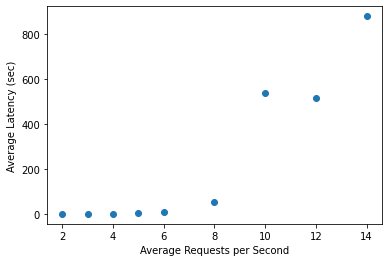

In [24]:
plt.scatter(agg_results.index, agg_results["latency", "mean"])
plt.xlabel("Average Requests per Second")
plt.ylabel("Average Latency (sec)")

## Optimized implementation

Now let's redo this baseline using zero-copy model loading.
First we'll need to convert the models into a format that can be loaded without copying
data. As we saw earlier, each model is actually a pipeline of multiple operations. However, the transformer-based model
at the center of this pipeline is orders of magnitude larger and more CPU-intensive than everything else, so we'll only apply zero-copy loading to that part.



In [25]:
# Restart Ray to prevent the actors from the baseline run from
# reserving CPUs.
serve.shutdown()
reboot_ray()
serve.start()

# Wait a moment to make sure that all log output goes to this cell
time.sleep(1.)

(ServeController pid=66803) 2022-02-09 18:18:52,767	INFO deployment_state.py:932 -- Removing 1 replicas from deployment 'en_intent'. component=serve deployment=en_intent
(ServeController pid=66803) 2022-02-09 18:18:52,774	INFO deployment_state.py:932 -- Removing 1 replicas from deployment 'en_sentiment'. component=serve deployment=en_sentiment
(ServeController pid=66803) 2022-02-09 18:18:52,778	INFO deployment_state.py:932 -- Removing 1 replicas from deployment 'en_qa'. component=serve deployment=en_qa
(ServeController pid=66803) 2022-02-09 18:18:52,781	INFO deployment_state.py:932 -- Removing 1 replicas from deployment 'en_generate'. component=serve deployment=en_generate
(ServeController pid=66803) 2022-02-09 18:18:52,784	INFO deployment_state.py:932 -- Removing 1 replicas from deployment 'es_intent'. component=serve deployment=es_intent
(ServeController pid=66803) 2022-02-09 18:18:52,787	INFO deployment_state.py:932 -- Removing 1 replicas from deployment 'es_sentiment'. component=se

### Introducing `zerocopy`

We've created a Python package, `zerocopy`, with the model rewrite code from our previous post (TODO: Publish the package to PyPI).

To use that package, you'll need to install it with `pip`, then import it into your script.

```python
import zerocopy
```


(TODO: Insert description of how `zero_copy` strips off the weights of a model
and provides a way to reconsitute them from Plasma)



### Applying zero-copy model loading to our models

The low-level process works for all of our example models. Here it is in action with the question answering model.

In [26]:
# Call the QA model directly
qa = transformers.pipeline('question-answering', model=QA_MODEL_NAME)
qa_tokens = qa.tokenizer(qa_input["question"], qa_input["context"], 
                         return_tensors="pt")
qa.model(**qa_tokens)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 3.7534, -8.7741, -9.1023, -6.6326, -8.7627, -8.6893, -9.7706, -9.6873,
         -9.6512, -4.1902, -7.6596, -8.5491, -7.9478, -7.5671, -9.0784, -8.2897,
         -7.5410, -5.9760, -7.2943, -6.4249, -9.3297, -8.9922, -7.9955, -8.9485,
         -8.7506, -6.1065, -8.2273, -8.4471, -8.9334, -2.9227, -2.8201, -4.6316,
         -5.5576, -5.7634, -5.8722, -5.9716, -6.2091, -6.0458, -5.3727, -9.8484,
         -8.4069, -7.6116, -5.1946, -8.7245, -4.3297, -8.3712, -8.5934, -4.6927,
         -8.6297, -5.4113, -8.5218, -6.5587, -6.0347, -9.0888, -3.9168, -3.7715,
         -4.0178, -5.5528, -6.2156, -6.1800, -6.1387, -6.2229, -6.4473, -6.3201,
         -6.2259, -8.2617, -8.0752, -8.5442, -7.0337, -5.3172, -7.1967, -8.6134,
         -5.5957, -9.0524, -8.1817, -7.5553, -7.3491, -8.5218, -7.5425, -7.8877,
         -8.3360, -8.1147, -5.0947, -5.1871, -6.5926, -6.7610, -6.7855, -6.8672,
         -6.9245, -6.7498, -7.7118, -8.6336, -8.0724, -7

In [27]:
# Call the QA model via `call_model`. Results should be the same as 
# the previous cell.
qa_model_ref = ray.put(zerocopy.extract_tensors(qa.model))
ray.get(zerocopy.call_model.remote(qa_model_ref, [], qa_tokens))

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 3.7534, -8.7741, -9.1023, -6.6326, -8.7627, -8.6893, -9.7706, -9.6873,
         -9.6512, -4.1902, -7.6596, -8.5491, -7.9478, -7.5671, -9.0784, -8.2897,
         -7.5410, -5.9760, -7.2943, -6.4249, -9.3297, -8.9922, -7.9955, -8.9485,
         -8.7506, -6.1065, -8.2273, -8.4471, -8.9334, -2.9227, -2.8201, -4.6316,
         -5.5576, -5.7634, -5.8722, -5.9716, -6.2091, -6.0458, -5.3727, -9.8484,
         -8.4069, -7.6116, -5.1946, -8.7245, -4.3297, -8.3712, -8.5934, -4.6927,
         -8.6297, -5.4113, -8.5218, -6.5587, -6.0347, -9.0888, -3.9168, -3.7715,
         -4.0178, -5.5528, -6.2156, -6.1800, -6.1387, -6.2229, -6.4473, -6.3201,
         -6.2259, -8.2617, -8.0752, -8.5442, -7.0337, -5.3172, -7.1967, -8.6134,
         -5.5957, -9.0524, -8.1817, -7.5553, -7.3491, -8.5218, -7.5425, -7.8877,
         -8.3360, -8.1147, -5.0947, -5.1871, -6.5926, -6.7610, -6.7855, -6.8672,
         -6.9245, -6.7498, -7.7118, -8.6336, -8.0724, -7

For convenience, the `zerocopy` library includes a function `rewrite_pipeline` that takes  transforms any models embedded into a model pipeline into Ray tasks that use zero-copy model loading to load weights. If we apply this function to our question answering pipeline, the resulting rewritten pipeline faithfully performs all the pre- and post-processing that the original pipeline performed. However, this rewritten pipeline runs the embedded PyTorch model in remote Ray tasks.

In [28]:
zero_copy_qa = zerocopy.rewrite_pipeline(qa)
print(f"Before rewrite: {qa(qa_input)}")
print(f" After rewrite: {zero_copy_qa(qa_input)}")

Before rewrite: {'score': 4.278938831703272e-06, 'start': 483, 'end': 484, 'answer': '5'}
 After rewrite: {'score': 4.278938831703272e-06, 'start': 483, 'end': 484, 'answer': '5'}


The time to invoke the rewritten model once is almost the same as running the model locally.

In [29]:
# Compare timings
print("       Time to run locally: ", end="")
%timeit qa(qa_input)
print("Time to run with zero-copy: ", end="")
%timeit zero_copy_qa(qa_input)

       Time to run locally: 533 ms ± 5.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time to run with zero-copy: 551 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


If we run inference multiple times, `zero_copy.call_model()` can send those inference requests to separate Ray tasks that run in parallel.

In [30]:
def run_local(num_repeats: int):
    for _ in range(num_repeats):
        qa.model(**qa_tokens)


def run_zero_copy(num_repeats: int):
    futures = [zerocopy.call_model.remote(zero_copy_qa.model._model_ref, [], qa_tokens) 
               for _ in range(num_repeats)]
    ray.get(futures)


NUM_REPEATS = 16
print(f"       Time to run {NUM_REPEATS} times locally: ", end="")
%timeit -r 3 run_local(NUM_REPEATS)
print(f"Time to run {NUM_REPEATS} times with zero-copy: ", end="")
%timeit -r 3 run_zero_copy(NUM_REPEATS)

       Time to run 16 times locally: 8.64 s ± 17.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Time to run 16 times with zero-copy: 3.98 s ± 104 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [31]:
# Try the same thing with the intent model
intent = IntentPipeline()
intent(intent_input['context'])

'to eat'

In [32]:
zero_copy_intent = zerocopy.rewrite_pipeline(intent, ('__call__', 'generate'))
zero_copy_intent(intent_input['context'])

'to eat'

In [33]:
print("       Time to run locally: ", end="")
%timeit intent(intent_input['context'])
print("Time to run with zero-copy: ", end="")
%timeit zero_copy_intent(intent_input['context'])

       Time to run locally: 299 ms ± 3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time to run with zero-copy: 306 ms ± 3.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
intent_tokens = intent._tokenizer([intent_input['context']], return_tensors='pt')

def run_local(num_repeats: int):
    for _ in range(num_repeats):
        intent._model.generate(
            input_ids=intent_tokens['input_ids'], 
            attention_mask=intent_tokens['attention_mask'],
            max_length=128)

def run_zero_copy(num_repeats: int):
    futures = [zerocopy.call_model.remote(
        zero_copy_intent._model._model_ref, [], 
            {
                'input_ids': intent_tokens['input_ids'],
                'attention_mask': intent_tokens['attention_mask'],
                'max_length': 128
            },
        'generate') 
            for _ in range(num_repeats)]
    ray.get(futures)


NUM_REPEATS = 100
print(f"Time to run {NUM_REPEATS} times with zero-copy: ", end="")
%timeit -r 3 run_zero_copy(NUM_REPEATS)
print(f"       Time to run {NUM_REPEATS} times locally: ", end="")
%timeit -r 3 run_local(NUM_REPEATS)

Time to run 100 times with zero-copy: 

(call_model pid=68117) 


14.5 s ± 87.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
       Time to run 100 times locally: 33.9 s ± 107 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


As in the baseline implementation, we can wrap the question answering pipeline in a Ray Serve endpoint with just a few lines of Python.

In [35]:
class ZeroCopyQA:
    def __init__(self):
        super().__init__()
        self._pipeline = zerocopy.rewrite_pipeline(
            transformers.pipeline('question-answering', 
                                  model=QA_MODEL_NAME))
        self._threadpool = concurrent.futures.ThreadPoolExecutor()

    async def __call__(self, request: starlette.requests.Request):
        model_input = {
            'question': request.query_params['question'],
            'context': request.query_params['context']
        }
        result = await asyncio.get_running_loop().run_in_executor(
             self._threadpool, lambda: self._pipeline(model_input))
        return result


We can apply the same transformation to the other three models.

In [36]:
class ZeroCopyIntent:
    def __init__(self):
        self._pipeline = zerocopy.rewrite_pipeline(
            IntentPipeline(), ('__call__', 'generate'))
        self._threadpool = concurrent.futures.ThreadPoolExecutor()

    async def __call__(self, request: starlette.requests.Request):
        result = await asyncio.get_running_loop().run_in_executor(
             self._threadpool, 
            lambda: self._pipeline(request.query_params['context']))
        return {
            "intent": result
        }


class ZeroCopySentiment:
    def __init__(self):
        self._pipeline = zerocopy.rewrite_pipeline(SentimentPipeline())
        self._threadpool = concurrent.futures.ThreadPoolExecutor()

    async def __call__(self, request: starlette.requests.Request):
        result = await asyncio.get_running_loop().run_in_executor(
            self._threadpool, 
            lambda: self._pipeline(request.query_params['context']))
        return result

class ZeroCopyGenerate:
    def __init__(self):
        self._pipeline = zerocopy.rewrite_pipeline(transformers.pipeline(
            'text-generation',
            model=GENERATE_MODEL_NAME, 
            pad_token_id=GPT2_TOKEN_PAD_ID),
            ('__call__', 'generate'))
        self._max_length = 30
        self._num_return_sequences = 1
        self._threadpool = concurrent.futures.ThreadPoolExecutor()

    async def __call__(self, request: starlette.requests.Request):
        model_input = request.query_params['context']
        result = await asyncio.get_running_loop().run_in_executor(
            self._threadpool, 
            lambda: self._pipeline(
                model_input,
                max_length=self._max_length,
                num_return_sequences=self._num_return_sequences))
        return result
    


As before, we can wrap these classes as Ray Serve deployments, one deployment per model.

In [37]:
zero_copy_deployments = {}  
for lang in LANGUAGES:
    zero_copy_deployments[(lang, 'intent')] = (
        serve.deployment(ZeroCopyIntent, f'{lang}_intent',
                         ray_actor_options={"num_cpus": 0.1}))
    zero_copy_deployments[(lang, 'sentiment')] = (
        serve.deployment(ZeroCopySentiment, f'{lang}_sentiment',
                         ray_actor_options={"num_cpus": 0.1}))
    zero_copy_deployments[(lang, 'qa')] = (
        serve.deployment(ZeroCopyQA, f'{lang}_qa',
                         ray_actor_options={"num_cpus": 0.1}))
    zero_copy_deployments[(lang, 'generate')] = (
        serve.deployment(ZeroCopyGenerate, f'{lang}_generate',
                         ray_actor_options={"num_cpus": 0.1}))
    
for d in zero_copy_deployments.values():
    d.deploy(_blocking=False)
    
# Wait a moment so log output doesn't go to the next cell's output
time.sleep(12.)

2022-02-09 18:23:49,101	INFO api.py:242 -- Updating deployment 'en_intent'. component=serve deployment=en_intent
2022-02-09 18:23:49,115	INFO api.py:242 -- Updating deployment 'en_sentiment'. component=serve deployment=en_sentiment
2022-02-09 18:23:49,172	INFO api.py:242 -- Updating deployment 'en_qa'. component=serve deployment=en_qa
2022-02-09 18:23:49,186	INFO api.py:242 -- Updating deployment 'en_generate'. component=serve deployment=en_generate
(ServeController pid=68077) 2022-02-09 18:23:49,120	INFO deployment_state.py:912 -- Adding 1 replicas to deployment 'en_intent'. component=serve deployment=en_intent
(ServeController pid=68077) 2022-02-09 18:23:49,143	INFO deployment_state.py:912 -- Adding 1 replicas to deployment 'en_sentiment'. component=serve deployment=en_sentiment
2022-02-09 18:23:49,199	INFO api.py:242 -- Updating deployment 'es_intent'. component=serve deployment=es_intent
2022-02-09 18:23:49,218	INFO api.py:242 -- Updating deployment 'es_sentiment'. component=serve 

(en_qa pid=68139) 


(en_intent pid=68128) The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
(es_intent pid=68116) The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
(zh_intent pid=68072) The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [38]:
# Make sure all these models are working
params = urllib.parse.urlencode(intent_input)
requests.get(f"http://127.0.0.1:8000/en_intent?{params}").json()

{'intent': 'to eat'}

In [39]:
params = urllib.parse.urlencode(sentiment_input)
requests.get(f"http://127.0.0.1:8000/en_sentiment?{params}").json()

[['positive', 0.5419477820396423],
 ['neutral', 0.38251084089279175],
 ['negative', 0.07554134726524353]]

In [ ]:
params = urllib.parse.urlencode(qa_input)
requests.get(f"http://127.0.0.1:8000/en_qa?{params}").json()

{'score': 4.278938831703272e-06, 'start': 483, 'end': 484, 'answer': '5'}

In [ ]:
params = urllib.parse.urlencode(generate_input)
requests.get(f"http://127.0.0.1:8000/en_generate?{params}").json()

[{'generated_text': 'All your base are going to need to be the most expensive available on the marketplace.\n\nIf you like to have a little more flexibility, then'}]

### Benchmarking the zero-copy version

We've deployed these models to the same URLs, so the benchmark code from before should work without
any changes.

In [ ]:
# Quick test run
run_benchmark(call_model, 5, 10, MODEL_ID_TO_PARAMS)

,request_id,model_num,lang_code,model_type,desired_start,actual_start,end,latency
0,0,1,en,sentiment,0.000000,0.001177,0.110922,0.109745
1,1,1,en,sentiment,0.125000,0.125200,0.222170,0.096970
2,2,0,en,intent,0.250000,0.250172,0.587223,0.337051
3,3,2,en,qa,0.375000,0.379270,1.181423,0.802153
4,4,0,en,intent,0.500000,0.503959,0.947586,0.443627
5,5,0,en,intent,0.625000,0.628806,6.416492,5.787686
6,6,0,en,intent,0.750000,0.754164,6.505053,5.750889
7,7,1,en,sentiment,0.875000,0.879503,5.283766,4.404263
8,8,1,en,sentiment,1.000000,1.003898,7.087968,6.084070
9,9,0,en,intent,1.142857,1.143836,6.429772,5.285936


In [ ]:
# Run the benchmark at multiple different request rates
to_concat = []
for request_rate in REQUEST_RATES:
    print(f"Running at {request_rate} requests/sec.")
    times = run_benchmark(call_model, request_rate, RUNNING_TIME_SEC,
                          MODEL_ID_TO_PARAMS)
    times.insert(0, "request_rate", request_rate)
    to_concat.append(times)

results_zerocopy = pd.concat(to_concat)

Running at 2 requests/sec.
Running at 3 requests/sec.
Running at 4 requests/sec.
Running at 5 requests/sec.
Running at 6 requests/sec.
(call_model pid=68614) 


(call_model pid=68662) 


Running at 8 requests/sec.
Running at 10 requests/sec.
Running at 12 requests/sec.
Running at 14 requests/sec.


(call_model pid=68858) 
(call_model pid=68893) 


(call_model pid=68939) 


In [ ]:
agg_results_zerocopy = results_zerocopy.groupby("request_rate").aggregate({
    "latency": ["mean", "median", "max"]})
agg_results_zerocopy

latency                        
                    mean      median         max
request_rate                                    
2               0.661407    0.332965    3.544607
3               0.557090    0.333867    4.106008
4               2.074884    0.891919   10.622166
5               1.587614    0.905039    6.720857
6               1.896304    1.306567    8.264216
8               2.876169    2.832798    9.643580
10              2.691245    2.840891    9.052174
12              8.184824    9.026742   18.863758
14            208.546370  106.358101  606.104136

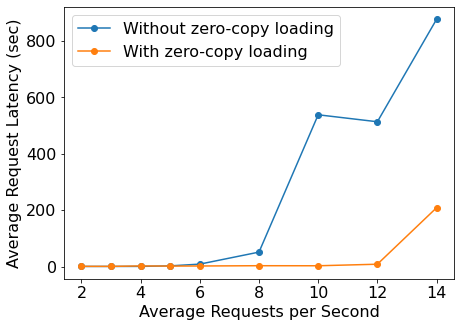

In [ ]:
# Plot the two sets of results against each other.
plt.rcParams.update({"font.size": 16})
plt.figure(figsize=(7, 5))
plt.plot(agg_results.index, agg_results["latency", "mean"],
         "-o", label="Without zero-copy loading")
plt.plot(agg_results_zerocopy.index, 
         agg_results_zerocopy["latency", "mean"],
         "-o", label="With zero-copy loading")
plt.xlabel("Average Requests per Second")
plt.ylabel("Average Request Latency (sec)")
plt.legend()

In [ ]:
# Old code defined an actor

# class ModelCallback:
#     def __init__(self, model_ref: ray.ObjectRef):
#         self._model_ref = model_ref

#     def __call__(self, *args: Any, **kwargs: Any) -> Any:
#         return ray.get(call_model.remote(self._model_ref, args, kwargs))

# @ray.remote
# class QAModelZeroCopyActor:
#     def __init__(self):
#         self._qa = transformers.pipeline("question-answering", model=model_name)
#         self._model_ref = ray.put(zerocopy.extract_tensors(self._qa.model))
#         self._qa.model = ModelCallback(self._model_ref)

#     def run_inference(self, input_: Dict[str, str]) -> Dict[str, Any]:
#         return self._qa(input_)

# zero_copy_actors = [QAModelZeroCopyActor.options(max_concurrency=8).remote() 
#                     for _ in range(NUM_QA_MODELS)]
# ray.get(zero_copy_actors[0].run_inference.remote(qa_input))

In [ ]:
# Old version of code for zero-copy QA model

# class ZeroCopyQAModel:
#     def __init__(self):
#         # TODO: Move this rewrite to the `zerocopy` library.
#         # Load the entire pipeline, then copy the model portion to Plasma.
#         self._qa = transformers.pipeline("question-answering", model=model_name)
#         model_ref = ray.put(zerocopy.extract_tensors(self._qa.model))

#         # Replace the pipeline's model with a callback that farms out work to
#         # Ray tasks.
#         class _ModelCallback:
#             def __call__(self, *args, **kwargs):
#                 return ray.get(call_model_zero_copy.remote(model_ref, args, kwargs))
#         self._qa.model = _ModelCallback()

#         # Use a threadpool because the model is called from pre/postprocessing code
#         # that is not asyncio-aware
#         self._threadpool = concurrent.futures.ThreadPoolExecutor()

#     async def __call__(self, request: starlette.requests.Request):
#         # Pull model inputs from URL query parameters.
#         # A production version of this code would sanitize these strings.
#         model_input = {
#             "question": request.query_params["question"],
#             "context": request.query_params["context"]
#         }
#         result = await asyncio.get_running_loop().run_in_executor(
#             self._threadpool, lambda: self._qa(model_input))
#         return result

#     def __del__(self):  # Ray Serve needs this callback
#         pass


# # Define endpoints
# NUM_QA_MODELS = 12
# deployments = [
#     serve.deployment(ZeroCopyQAModel, f"qa{model_num}",
#                      ray_actor_options={"num_cpus": 0.1})
#     for model_num in range(NUM_QA_MODELS)
# ]

# for d in deployments:
#     d.deploy(_blocking=False)

# # Wait a moment so log output doesn't go to the next cell's output
# time.sleep(1.)